In [3]:
# import our usual things
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import geopandas 
import ipyleaflet
import numpy as np
import bqplot

# Plotting earthquake sensor data on the US map with cartopy
* we'll be plotting the activity of earthquake sensors across the US in response to the 2011 earthquake in Japan
* more info can be found here: https://ds.iris.edu/ds/nodes/dmc/specialevents/2011/03/11/tohoku-japan-earthquake/
* a few cool movies based on this data & others collected & simulated about this event can be found here: http://www.seismicsoundlab.org/?page_id=338

Show this movie: https://vimeo.com/187740441 (we'll talk more about what we do and don't like about this later)

In [6]:
# using pandas to access the data per usual
import pandas as pd

In [8]:
locations = pd.read_csv("/Users/jnaiman/Downloads/location.txt", delimiter="\t",
            header = None, names = ["longitude", "latitude", "empty1", "empty2"])

In [9]:
locations

,longitude,latitude,empty1,empty2
0,-98.683,27.065,1,#
1,-98.102,26.938,1,#
2,-98.068,26.463,1,#
3,-117.110,32.889,1,#
4,-107.790,32.532,1,#
...,...,...,...,...
433,-95.623,33.198,1,#
434,-94.985,33.260,1,#
435,-94.182,33.242,1,#
436,-93.400,33.258,1,#


Now we'll do some data cleaning:

In [10]:
del locations["empty1"], locations["empty2"]

In [11]:
# we can check out how these look - lat-long pairs
locations

,longitude,latitude
0,-98.683,27.065
1,-98.102,26.938
2,-98.068,26.463
3,-117.110,32.889
4,-107.790,32.532
...,...,...
433,-95.623,33.198
434,-94.985,33.260
435,-94.182,33.242
436,-93.400,33.258


Ok, lets start thinking about how to link this data to the actual readings of each detector.  First, lets read in the detector data:

In [ ]:
seismic = pd.read_csv("/Users/jnaiman/Downloads/data_tohoku_norm_transpose.csv",
           header = None)

In [21]:
# what is the shape of this data vs the location data?
seismic.shape, locations.shape

((14401, 438), (438, 2))

So, this is telling us
 1. that there are 438 stations in total
 1. what about 14401?  this is the length of time in seconds that each detector recorded

In [22]:
14401/(60*60)
# so about 4 hours worth of data in 
#  second increments

4.000277777777778

Lets check out this seismic data with a widget

In [26]:
import ipywidgets
@ipywidgets.interact(station = (0, 437))
def plot(station = 0):
    plt.plot(seismic[station])
    plt.xlabel("Time in sec")
    # note: this is normalized to peak amplitude for this event
    #  so, in essence, unitless
    plt.ylabel("Normalized Displacement") 
    plt.ylim(-1, 1)
    plt.show()
    
# the above allows us to see how each detector reacted to
#  this earthquake

interactive(children=(IntSlider(value=0, description='station', max=437), Output()), _dom_classes=('widget-int…

In [27]:
# one thing you might notice depending on your computer's age
# is that this can get a little laggy
#  ultimately, we want to use the full dataset
#  but for the purposes of doing things now, or debugging at home
#  lets use a downsampled dataset

# recall our origional sizes
seismic.shape, locations.shape

((14401, 438), (438, 2))

In [28]:
# we have 3 options: we can decrese the number of stations, 
#  or the number of time samples, or both
# for illustration purposes, lets do both

nstations = 300 # downsample to 300
ntimes = 1440 # factor of 10

import numpy as np
stationsIndex = np.random.choice(range(locations.shape[0]-1), 
                                  nstations, replace=False)
timesIndex = np.random.choice(range(seismic.shape[0]-1), 
                                  ntimes, replace=False)

# sort each
stationsIndex.sort()
timesIndex.sort()

In [29]:
locations2 = locations.loc[stationsIndex]
seismic2 = seismic.loc[timesIndex,stationsIndex]
seismic2.shape, locations2.shape
# sweet

((1440, 300), (300, 2))

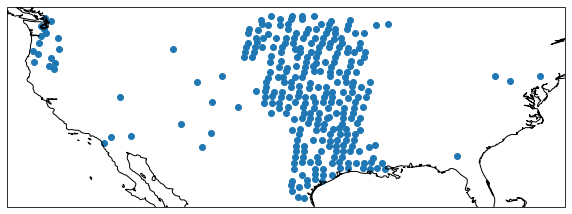

In [30]:
# lets real quick redo our plots and take a look
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, 
                     projection = cartopy.crs.LambertCylindrical())
ax.scatter(locations2["longitude"], locations2["latitude"], 
           transform = cartopy.crs.PlateCarree())
ax.coastlines()

In [31]:
# and redo our widget
import ipywidgets
@ipywidgets.interact(station = (0,nstations-1))
def plot(station = 0):
    plt.plot(seismic2.iloc[:,station])
    plt.xlabel("Time in sec")
    # note: this is normalized to peak amplitude for this event
    #  so, in essence, unitless
    plt.ylabel("Normalized Displacement") 
    plt.ylim(-1, 1)
    plt.show()

interactive(children=(IntSlider(value=0, description='station', max=299), Output()), _dom_classes=('widget-int…

In [32]:
# note, we can also do the above plot with bqplot as well:
import bqplot

# scales
x_sc = bqplot.LinearScale()
y_sc = bqplot.LinearScale()

# marks
lines = bqplot.Lines(x = seismic2.index.values, 
                     y = seismic2.iloc[:,0],
                    scales = {'x': x_sc, 'y': y_sc})

# axes
x_ax = bqplot.Axis(scale = x_sc)
y_ax = bqplot.Axis(scale = y_sc, orientation = 'vertical')

# combine into figure
fig = bqplot.Figure(marks = [lines], axes = [x_ax, y_ax])

# create our slider using ipywidgets
slider = ipywidgets.IntSlider(min=0, max=nstations-1)
y_sc.min = -1.0
y_sc.max = 1.0

# create a linking function for slider & plot
def update_slider(event):
    lines.y = seismic2.iloc[:,event['new']]

slider.observe(update_slider, 'value')

display(ipywidgets.VBox([slider, fig]))

# note that this is much more responsive now
#  than we we did this ourselves
# bqplots ftw

In [33]:
# ok, so we are now super into linking THING A with THING B
#  so lets link our sesmic data with its location on the map
#  we can do this with cartopy & matplotlib

@ipywidgets.interact(station = (0, nstations, 1), 
                     t = (0, ntimes, 1))
def plot(station = 0, t = 0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211, 
                         projection = cartopy.crs.LambertCylindrical())
    colors = seismic2.iloc[t]
    ax.scatter(locations2["longitude"], 
               locations2["latitude"], 
               transform = cartopy.crs.PlateCarree(),
               c = colors)
    ax.coastlines()

    ax = fig.add_subplot(212)
    ax.plot(seismic2.index.values, seismic2.iloc[:,station])
    ax.set_ylim(-1, 1)
    plt.show()

interactive(children=(IntSlider(value=0, description='station', max=300), IntSlider(value=0, description='t', …

# Activity #3: Info viz maps with bqplot

In [34]:
# with bqplot

map_mark = bqplot.Map(scales={'projection': bqplot.AlbersUSA()})
fig = bqplot.Figure(marks=[map_mark], title='Basic Map Example')
fig

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, marks=[Map(hovered_styles={'hovered_fill…

In [35]:
# can make a statemap instead
#(1)
sc_geo = bqplot.AlbersUSA()
state_data = bqplot.topo_load('map_data/USStatesMap.json')

# (2) 
def_tt = bqplot.Tooltip(fields=['id', 'name'])

states_map = bqplot.Map(map_data=state_data, 
                        scales={'projection':sc_geo}, 
                        tooltip=def_tt)

# (2) grab interactions
states_map.interactions = {'click': 'select', 'hover': 'tooltip'}

# (3) grab data directly from map
# we could also grab from the state_data itself
from states_utils import get_ids_and_names
ids, state_names = get_ids_and_names(states_map)


# lets make into arrays for ease
#state_names =np.array(state_names)
#ids = np.array(ids)
state_names, ids
# into arrays


# (4) data
def get_data_value(change):
    if change['owner'].selected is not None:
        for i,s in enumerate(change['owner'].selected):
            print(state_names[s == ids])
        
states_map.observe(get_data_value,'selected')

# (1)
fig=bqplot.Figure(marks=[states_map], 
                  title='US States Map Example',
                  fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0}) # try w/o first and see
fig

Figure(fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0}, marks=[Map(hovered_styles={'hovered_fill': '…

## Adding in some data to link to our usa map

In [36]:
# lets add in some exprot data
comm = pd.read_csv('/Users/jnaiman/Downloads/total_export.csv')

In [37]:
comm.loc[comm['State'] == 'Alabama'].values
# we note that these are formatted as strings - this means we'll have to 
#  do some formatting when we plot data

# also, note that the state name is the first column and not a number
# we'll also have to take care of this too

array([['Alabama', '574.6', '673.2', '530.0', '719.5', '724.4', '771.5',
        '695.6', '839.7', '1,050.4', '1,040.7', '1,131.7', '1,405.0',
        '1,469.6', '1,587.3', '1,510.1', '1,199.1', '1,207.6', '1,271.9']],
      dtype=object)

In [38]:
# grab years
years = list(comm.columns.values)
years = np.array(years[1:]) # get rid of state
# as numbers
years = years.astype('int')
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [39]:
sc_geo = bqplot.AlbersUSA()
state_data = bqplot.topo_load('map_data/USStatesMap.json')

def_tt = bqplot.Tooltip(fields=['id', 'name'])

states_map = bqplot.Map(map_data=state_data, scales={'projection':sc_geo}, tooltip=def_tt)
states_map.interactions = {'click': 'select', 'hover': 'tooltip'}

fig=bqplot.Figure(marks=[states_map], title='US States Map Example',
                  fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})


# lets also make a line plot
# second, the lineplot
x_scl = bqplot.LinearScale() 
y_scl = bqplot.LinearScale()
ax_xcl = bqplot.Axis(label='Year', scale=x_scl)
ax_ycl = bqplot.Axis(label='Total Export from State NA', 
                     scale=y_scl, 
                    orientation='vertical', side='left')
lines = bqplot.Lines(x = years, y = np.zeros(len(years)),
                    scales = {'x': x_scl, 'y': y_scl})
#print(lines)
fig_lines = bqplot.Figure(marks = [lines], 
                          axes = [ax_ycl, ax_xcl],)

# let do something additive for all states selected
def get_data_value(change):
    exports = np.zeros(len(years))
    snames = ''
    if change['owner'].selected is not None:
        for i,s in enumerate(change['owner'].selected):
            sn = state_names[s == ids][0]
            snames += sn + ', '
            # because of formatting, things are in arrays hence [0]
            #  also, take out state name hence [1:]
            exports_in=comm.loc[comm['State'] == sn].values[0][1:]
            # there are ","'s in exports we gotta take out
            exports_in = np.array([exports_in[i].replace(',','') for i in range(len(exports_in))])
            exports = np.add(exports, exports_in.astype('float64'))
        lines.y = exports
        ax_ycl.label='Total Export from ' + snames
    else:
        lines.y = np.zeros(len(exports))
        ax_ycl.label='Total Export from NA'

states_map.observe(get_data_value,'selected')

# some formatting for vertical
#fig_lines.layout.max_height='250px'
#fig_lines.layout.min_width='800px'
#fig.layout.min_width='800px'
#ipywidgets.VBox([fig_lines,fig])
ipywidgets.HBox([fig,fig_lines])

# Activity:

Using the tools and resources we talked about today - create a map with at least 2 layers

Bonus: make it interactive and part of a dashboard!

FYI: this will be part of the extra credit over the break!